In [1]:
import numpy as np
import os
from scipy.io import loadmat
import random
import cv2
from sklearn.feature_extraction import image
from tensorflow.keras.layers import (Input,Activation, Conv2D, Dropout, Convolution2D,UpSampling2D)
from tensorflow.keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,Conv2DTranspose,
                  Add,MaxPooling2D,MaxPooling3D, Input, Concatenate,BatchNormalization,LeakyReLU)
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.optimizers import Adam
import os, math
import matplotlib
import matplotlib.pyplot as plt
import cv2
import argparse
import numpy as np
import tensorflow as tf
import random
from skimage import io, img_as_uint, img_as_ubyte
import tensorflow.keras.backend as K
from tqdm import tqdm
from statistics import mean
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
from numba import cuda 
import matplotlib.image as mpimg
from PIL import Image
import pickle

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [3]:
tf.__version__

'2.2.0'

In [4]:
tf.test.is_gpu_available(cuda_only=True) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
class data_utils():
    def __init__(self,X_dir,y_dir):
        self.X_dir = X_dir
        self.y_dir = y_dir
        self.train_size =  len(os.listdir(y_dir))
        self.order = np.arange(self.train_size)
        np.random.shuffle(self.order)
        self.X_files = sorted(os.listdir(self.X_dir))
        self.y_files = sorted(os.listdir(self.y_dir))
        self.image_dims = (512,512)

    def append_image(self,data_dir,data_save_path,image_size=None,resize=False,save=True):
      img_list = []
      count = 0
      for img in sorted(os.listdir(data_dir)):
        img_path = os.path.join(data_dir, img)
        image = cv2.imread(img_path)
        img_list.append(image)
        count += 1
        print(np.array(img_list).shape,end='\r')
      if save:
        try:
          np.save(data_save_path, np.array(img_list))
          print('\nsaved....... ', os.path.split(data_save_path)[1], np.array(img_list).shape)
        except:
          print("[WARNING]..Exception Occured ......!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
          print('[INFO] To save image array as numpy file provide location with file name')
      return np.array(img_list)
    
    def load_train_clean(self,data_dir, data_save_dir, file_save_name):
      if os.path.exists(data_save_dir+'/'+file_save_name+'.npy'):
        train_data = np.load(data_save_dir+'/'+file_save_name+'.npy')
        print('Data loaded ........................',file_save_name+'.npy', train_data.shape)
      else:
        train_data = self.append_image(data_dir, data_save_dir, file_save_name)
      return train_data
    
    def load_gt(self,data_dir, data_save_dir, file_save_name):
      if os.path.exists(data_save_dir+'/'+file_save_name+'.npy'):
        final_numpyData = np.load(data_save_dir+'/'+file_save_name+'.npy')
      else:
        for i,pic in enumerate(sorted(os.listdir(data_dir))):
          x = loadmat(data_dir+'/'+pic)
          mat_img = x['cube']
          if(i==0):
            final_numpyData = mat_img
          elif i==1:
            final_numpyData = np.stack([final_numpyData,mat_img])
          else:
            final_numpyData = np.concatenate([final_numpyData, np.expand_dims(mat_img,axis=0)])
        try:
          np.save(data_save_dir+'/'+file_save_name+'.npy',final_numpyData)
          print('successfully saved',data_save_dir+'/'+file_save_name+'.npy',end='\n')
        except Exception as e:
          print("[WARNING]..Exception Occured ......!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
          print('[INFO] To save consolidated numpy file provide file_save_path with file name')
      print('Ground Truth data loaded...........', final_numpyData.shape)
      return final_numpyData

    def create_patches(self,arr,size,stride):
        patch_num = (int((arr.shape[0]-size)/stride)+1)*(int((arr.shape[1]-size)/stride)+1)
        return image.extract_patches_2d(arr, (size,size),max_patches=patch_num)

    def normalize(self,image):
        image = (image*2) - 1
        return image
    
    def load_data_batch(self,batch_size,batch_num,patch_num,make_patch = False,patch_size=256,patch_stride=128,resize_img=True):
        img_list = []
        spec_list = []
        cnt = 0
        start = batch_size*batch_num
        while cnt<batch_size and start+cnt != self.train_size:
            img = self.X_files[self.order[start+cnt]]
            spec = self.y_files[self.order[start+cnt]]
            img_path = os.path.join(self.X_dir, img)
            spec_path = os.path.join(self.y_dir,spec)
            image = cv2.imread(img_path)
            x = loadmat(spec_path)
            #print("image", image)
            spectral = x['cube']
            if resize_img:
                image = resize(image,self.image_dims)
                spectral = resize(spectral, self.image_dims)
            if make_patch:
                X_patches = self.create_patches(image,size=patch_size,stride=patch_stride)
                y_patches = self.create_patches(spectral,size=patch_size,stride=patch_stride)
                for i in range(len(X_patches)):
                    if patch_num == i:
                        return X_patches[i],y_patches[i]
#                     img_list.append(self.normalize(X_patches[i]))
#                     spec_list.append(self.normalize(y_patches[i]))
            else:
                img_list.append(image)
                spec_list.append(spectral)
            cnt += 1
        X = np.array(img_list)
        y = np.array(spec_list)
#         img_test = self.denormalize(X[0])
#         plt.imshow(img_test)
#         plt.show()
#         print("image ",img_test.max()," ",img_test.min())
#         spec_test = self.denormalize(y[0,:,:,25])
#         plt.imshow(spec_test)
#         plt.show()
#         print("spec ",spec_test.max()," ",spec_test.min())
# #         np.random.shuffle(X)
# #         np.random.shuffle(y)
        return X,y
    
    def load_random_set(self,batch_size,make_patch=True):
        chosen = random.sample(range(self.train_size),batch_size)
        img_list = []
        cnt = 0
        while cnt<batch_size:
            img = self.X_files[chosen[cnt]]
            img_path = os.path.join(self.X_dir, img)
            image = cv2.imread(img_path)
            image = resize(image,self.image_dims)
            if make_patch:
                patches = self.create_patches(image,size=64,stride=16)
                img_list += patches
            else:
                img_list.append(image)
            cnt += 1
        X = np.array(img_list)
        np.random.shuffle(X)
        return X
    
    def denormalize(self,img):
        img = (img+1)/2
        return img
        
    def show_sample(self,rgb,spec,real):
#         spec = self.denormalize(spec)
#         real = self.denormalize(real)
#         plt.imshow(spec[0,:,:,15],cmap = 'gray')
#         plt.show()
#         plt.imshow(real[0,:,:,15],cmap = 'gray')
#         plt.show()
#         self.denormalize(rgb)
#         self.denormalize(spec)
#         self.denormalize(real)
        plt.imshow(rgb[0])
        plt.show()
        f, axarr = plt.subplots(2,6)
        #axarr[0,0].imshow(rgb[0])
#         spec = self.denormalize(spec)
#         real = self.denormalize(real)
#         print(spec)
#         print(real)
        axarr[0,0].imshow(spec[0,:,:,5],cmap = 'gray')
        axarr[1,0].imshow(real[0,:,:,5],cmap = 'gray')
        axarr[0,1].imshow(spec[0,:,:,10],cmap = 'gray')
        axarr[1,1].imshow(real[0,:,:,10],cmap = 'gray')
        axarr[0,2].imshow(spec[0,:,:,15],cmap = 'gray')
        axarr[1,2].imshow(real[0,:,:,15],cmap = 'gray')
        axarr[0,3].imshow(spec[0,:,:,20],cmap = 'gray')
        axarr[1,3].imshow(real[0,:,:,20],cmap = 'gray')
        axarr[0,4].imshow(spec[0,:,:,25],cmap = 'gray')
        axarr[1,4].imshow(real[0,:,:,25],cmap = 'gray')
        axarr[0,5].imshow(spec[0,:,:,30],cmap = 'gray')
        axarr[1,5].imshow(real[0,:,:,30],cmap = 'gray')
        plt.show()
#         return spec



In [7]:
def mrae_loss(y_pred, y_true):
    difference = K.abs(y_true - y_pred)
    mrae = K.mean(difference)
    return mrae

In [10]:
class Model_PatchGAN():
    def __init__(self,image_size,LAMBDA = 100,patch_size = 70,only_last = 5,g_lr = 2e-4,d_lr=2e-4,beta_1=0.5,block1_channels = 64,block2_channels = 128,block3_channels = 256):
        self.image_size = image_size
        self.lmbda = LAMBDA
        self.hs_size = (image_size[0],image_size[1],31)
        self.only_last = only_last
        #self.generator_loss = generator_loss
        #self.discriminator_loss = discriminator_loss
        #self.gan_loss = gan_loss
        #self.optimizer = optimizer
        self.block1_channels = block1_channels
        self.block2_channels = block2_channels
        self.block3_channels = block3_channels
        self.patch_size = patch_size
        self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(g_lr, beta_1=beta_1)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(d_lr, beta_1=beta_1)
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        #self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,discriminator_optimizer=self.discriminator_optimizer,generator= generator,discriminator=discriminator)
        self.log_dir="./logs/"
        self.summary_writer = tf.summary.create_file_writer(self.log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    def residual_block(self,ip,channels):
        init = ip
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same')(ip)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same')(x)
        m = Concatenate(axis=3)([x, init])
        return m
    
    def downsample(self,filters, size, apply_batchnorm=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
        if apply_batchnorm:
            result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.LeakyReLU())
        return result

    def upsample(self,filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(tf.keras.layers.UpSampling2D(size=(2,2),data_format='channels_last',interpolation = 'bilinear'))
        result.add(tf.keras.layers.Conv2D(filters,size,strides = 1,padding='same'))
        #result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
        return result

    def UNet_Generator(self):
        inputs = tf.keras.layers.Input(shape=self.image_size)
        OUTPUT_CHANNELS = self.hs_size[-1]
        down_stack = [
            self.downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
            self.downsample(128, 4), # (bs, 64, 64, 128)
            self.downsample(256, 4), # (bs, 32, 32, 256)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
            self.downsample(512, 4), # (bs, 4, 4, 512)
            self.downsample(512, 4), # (bs, 2, 2, 512)
            self.downsample(512, 4), # (bs, 1, 1, 512)
        ]

        up_stack = [
            self.upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
            self.upsample(512, 4), # (bs, 16, 16, 1024)
            self.upsample(256, 4), # (bs, 32, 32, 512)
            self.upsample(128, 4), # (bs, 64, 64, 256)
            self.upsample(64, 4), # (bs, 128, 128, 128)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 3)
        x = inputs
        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])
        x = last(x)
        return tf.keras.Model(inputs=inputs, outputs=x)
    
    def residual_block(self,ip,channels):
        init = ip
        initializer = tf.random_normal_initializer(0., 0.02)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same',kernel_initializer= initializer)(ip)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same',kernel_initializer= initializer)(x)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same',kernel_initializer= initializer)(x)
        x = Convolution2D(channels, (3, 3), activation='linear', padding='same',kernel_initializer= initializer)(x)
        m = Concatenate(axis=3)([x, init])
        return m
    
    def make_generator(self):
        inp = Input(self.image_size)
        C1 = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(inp)
        x = C1
        x = self.residual_block(x,self.block1_channels)
        x = Activation('relu')(x)
        x = self.residual_block(x,self.block2_channels)
        x = Activation('relu')(x)
        x = self.residual_block(x,self.block3_channels)
        x = Activation('relu')(x)
        Cout = Conv2D(31, kernel_size=(3,3), padding='same', activation='relu')(x)
        model = Model(inp, Cout)
        return model
    
    def generator_loss_nolast(self,disc_generated_output, gen_output, target):
        gan_loss = self.loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
        l1_loss = tf.reduce_mean(tf.abs(tf.dtypes.cast(target, tf.float32) - gen_output))
        total_gen_loss = gan_loss + (self.lmbda * l1_loss)
        return total_gen_loss, gan_loss, l1_loss
    
    def generator_loss(self,disc_generated_output_all,disc_generated_output_last, gen_output, target):
        gan_loss = (1/2)*(self.loss_object(tf.ones_like(disc_generated_output_all), disc_generated_output_all) + self.loss_object(tf.ones_like(disc_generated_output_last), disc_generated_output_last))
        l1_loss = tf.reduce_mean(tf.abs(tf.dtypes.cast(target, tf.float32) - gen_output))
        total_gen_loss = gan_loss + (self.lmbda * l1_loss)
        return total_gen_loss, gan_loss, l1_loss
    
    
    def make_discriminator(self,only_last=0):
        in_src_image = Input(shape=self.image_size)
        # target image input
        if only_last:
            in_target_image = Input(shape = (self.image_size[0],self.image_size[1],self.only_last))
        else:
            in_target_image = Input(shape=self.hs_size)
        # concatenate images channel-wise
        merged = Concatenate()([in_src_image, in_target_image])
        # C64
        d = Conv2D(64, (4,4), strides=(2,2), padding='same')(merged)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        d = Conv2D(128, (4,4), strides=(2,2), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        d = Conv2D(256, (4,4), strides=(2,2), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C512
        d = Conv2D(512, (4,4), strides=(2,2), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        d = Conv2D(512, (4,4), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        #patch output
        d = Conv2D(1, (4,4), padding='same')(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model([in_src_image, in_target_image], patch_out)
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        return model
    
    def discriminator_loss(self,disc_real_output, disc_generated_output):
        real_loss = self.loss_object(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = self.loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss
    
    def make_gan(self,discriminator,generator):
        discriminator.trainable=False
        in_src = Input(shape = self.image_size)
        g_out = generator(in_src)
        dis_out = discriminator([in_src,g_out])
        gan = Model(in_src,[dis_out,g_out])
        opt = Adam(learning_rate=0.0002,beta_1=0.5)
        gan.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
        return gan
    
    def train_step_nolast(self,input_image, target, epoch):
        generator= self.make_generator()
        discriminator= self.make_discriminator()
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.generator_loss_nolast(disc_generated_output, gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)
            del(gen_output)
            del(disc_real_output)
            del(disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
        with self.summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    def train_step(self,input_image, target, epoch):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:
            generator= self.make_generator()
            discriminator_1= self.make_discriminator()
            discriminator_2= self.make_discriminator(only_last=1)
            gen_output = generator(input_image, training=True)
            disc_real_output_all = discriminator_1([input_image, target], training=True)
            disc_generated_output_all = discriminator_1([input_image, gen_output], training=True)
            disc_real_output_last = discriminator_2([input_image, target[:,:,:,-5:]], training=True)
            disc_generated_output_last = discriminator_2([input_image, gen_output[:,:,:,-5:]], training=True)
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.generator_loss(disc_generated_output_all, disc_generated_output_last, gen_output, target)
            disc1_loss = self.discriminator_loss(disc_real_output_all, disc_generated_output_all)
            disc2_loss = self.discriminator_loss(disc_real_output_last, disc_generated_output_last)

        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
        discriminator1_gradients = disc1_tape.gradient(disc1_loss,discriminator_1.trainable_variables)
        discriminator2_gradients = disc2_tape.gradient(disc2_loss,discriminator_2.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator1_gradients,discriminator_1.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator2_gradients,discriminator_2.trainable_variables))
        del(gen_output)
        del(disc_real_output_all)
        del(disc_generated_output_all)
        del(disc_real_output_last)
        del(disc_generated_output_last)
        with self.summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc1_loss', disc1_loss, step=epoch)
            tf.summary.scalar('disc2_loss', disc2_loss, step=epoch)
            
#     def train(self,X_dir,y_dir,epochs=1,batch_size=32):
#         data_loader = data_utils(X_dir=X_dir,y_dir = y_dir)
#         generator= self.make_generator()
#         discriminator= self.make_discriminator()
#         batch_count = int(data_loader.train_size / batch_size)
        
#         for e in range(1,epochs+1):
#             print("Epoch ",e,"/",epochs)
#             for i in tqdm(range(batch_count)):
#                 if (i+1) % 100 == 0:
#                      print()
#                 rgb,spec = data_loader.load_data_batch(batch_size=batch_size,batch_num=i,patch_num=0,make_patch=False)
# #                 rgb = rgb.reshape(1,rgb.shape[0],rgb.shape[1],rgb.shape[2])
# #                 spec = spec.reshape(1,spec.shape[0],spec.shape[1],spec.shape[2])
#                 self.train_step_nolast(rgb,spec,e)
#                 del(rgb)
#                 del(spec)
            
    
    def train(self,generator1,discriminator1,gan1,X_dir,y_dir,epochs=1,batch_size=32,resize_img=True):
        #(X_train, y_train, X_test, y_test) = load_all_data()
        data_loader = data_utils(X_dir=X_dir,y_dir = y_dir)
        generator= generator1
        print(generator)
        discriminator= discriminator1
        gan = gan1
        #generator,discriminator,gan = self.compile_all(generator,discriminator,gan)
        batch_count = int(data_loader.train_size / batch_size)
        n_patches_x = discriminator.output_shape[1]
        n_patches_y = discriminator.output_shape[2]
        mrae_l = {}
        
        for e in range(1,epochs+1):
            print("Epoch ",e,"/",epochs)
            i=0
            d_loss_1_l = []
            d_loss_2_l = []
            g_loss_l = []
            mrae = 0
            for _ in tqdm(range(batch_count)):
                #noise = np.random.normal(0,1,[batch_size,image_size[0],image_size[1],image_size[2]])
                #rand_image_list = np.random.randint(low=0,high=X_train.shape[0],size = batch_size)
                rgb,spec = data_loader.load_data_batch(batch_size=batch_size,batch_num=i,patch_num = 0,make_patch=False,resize_img=resize_img)
                #print("loaded_batch")
                generated_images = generator.predict(rgb)
                
                if (i+1)%50 == 0:
                    filename = "generator[%.6d,%.6d].h5"%(e,i+1)
                    generator.save(filename)
                    print('mrae[%.3f]' % (mrae/(i+1)))
                    mrae_l[filename] = (mrae/(i+1))
#                     print("generated")
#                     print(generated_images)
#                     print("real")
#                     print(spec)
                    _ = data_loader.show_sample(rgb,generated_images,spec)
                #print("images generated")
                image_batch = spec
                #X = np.concatenate([image_batch, generated_images])
                #y_dis=np.zeros(2*batch_size)
                #y_dis[:batch_size]=0.9
                y_true = np.ones((batch_size, n_patches_x, n_patches_y, 1))
                y_fake = np.zeros((batch_size, n_patches_x, n_patches_y, 1))
                discriminator.trainable=True
                d_loss_1 = discriminator.train_on_batch([rgb,spec], y_true)
                d_loss_2 = discriminator.train_on_batch([rgb,generated_images],y_fake)
                #X_gen = data_utils.load_random_set(batch_size=batch_size,make_patch=False)
                #y_gen = np.ones(batch_size)
                discriminator.trainable = False
                #print("discriminator_trained")
                g_loss,_,_ = gan.train_on_batch(rgb,[y_true,spec])
                mrae += mrae_loss(generated_images,spec)
                d_loss_1_l.append(d_loss_1)
                d_loss_2_l.append(d_loss_2)
                g_loss_l.append(g_loss)
                
                del(rgb)
                del(spec)
                del(y_true)
                del(y_fake)
                del(generated_images) 
                i+=1
            
            print('d1[%.3f] d2[%.3f] g[%.3f]' % (np.mean(np.array(d_loss_1)), np.mean(np.array(d_loss_2)), np.mean(np.array(g_loss))))
        save_obj(mrae_l,"mrae_losses")

In [12]:
patch_gan = Model_PatchGAN(image_size=(512,512,3))

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch  1 / 5


 11%|█         | 49/450 [02:44<22:30,  3.37s/it] 

mrae[0.078]


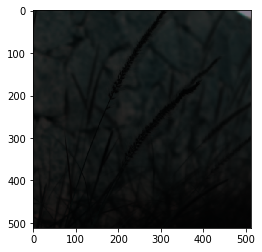

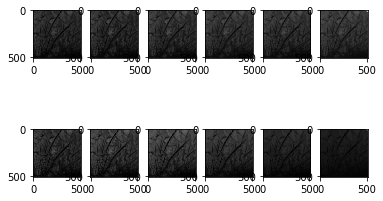

 22%|██▏       | 99/450 [05:18<18:33,  3.17s/it]

mrae[0.058]


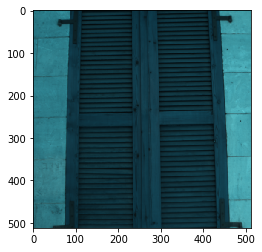

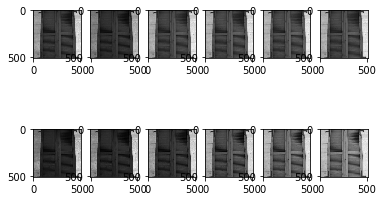

 33%|███▎      | 149/450 [08:03<16:04,  3.20s/it]

mrae[0.049]


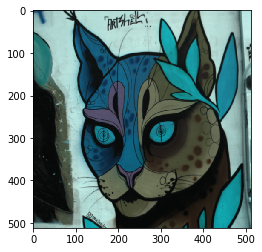

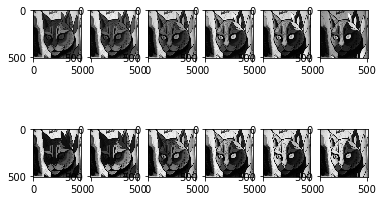

 44%|████▍     | 199/450 [10:44<16:12,  3.87s/it]

mrae[0.044]


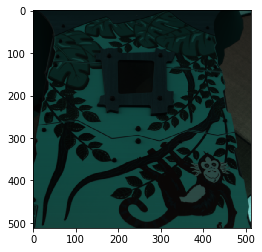

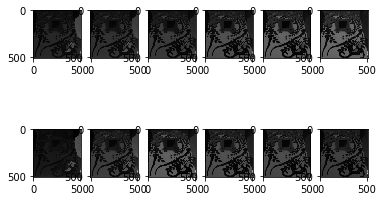

 55%|█████▌    | 249/450 [13:23<10:03,  3.00s/it]

mrae[0.040]


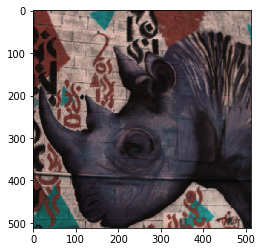

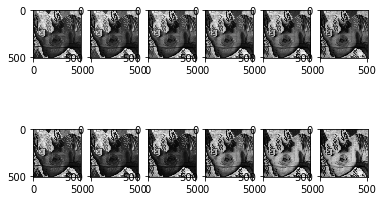

 66%|██████▋   | 299/450 [16:00<08:56,  3.55s/it]

mrae[0.037]


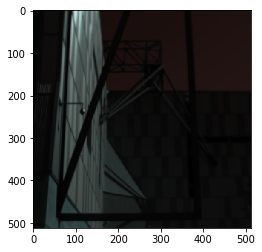

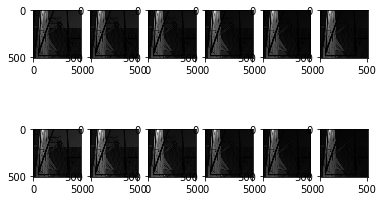

 78%|███████▊  | 349/450 [18:35<05:26,  3.23s/it]

mrae[0.034]


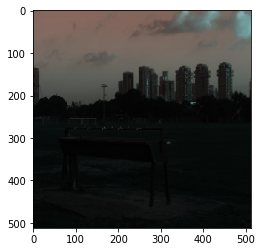

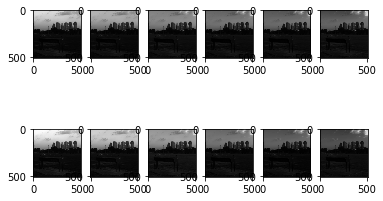

 89%|████████▊ | 399/450 [21:14<02:44,  3.22s/it]

mrae[0.033]


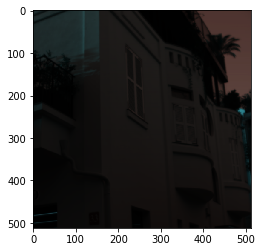

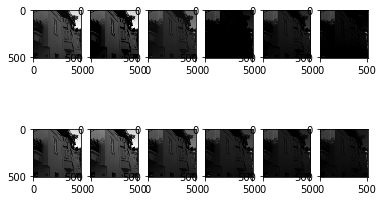

100%|█████████▉| 449/450 [23:51<00:02,  2.74s/it]

mrae[0.032]


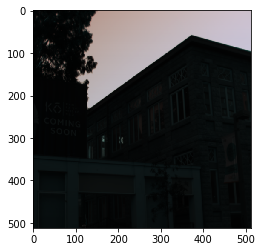

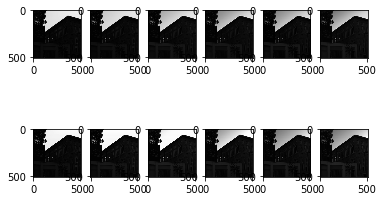

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.006] d2[0.008] g[2.199]
Epoch  2 / 5


 11%|█         | 49/450 [02:32<20:43,  3.10s/it]

mrae[0.022]


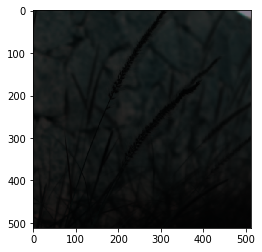

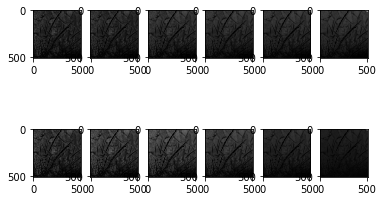

 22%|██▏       | 99/450 [05:19<19:30,  3.33s/it]

mrae[0.018]


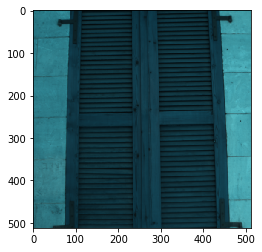

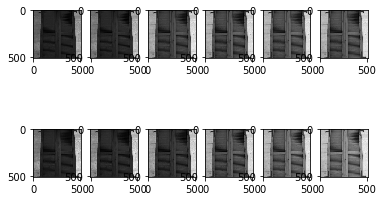

 33%|███▎      | 149/450 [07:52<14:38,  2.92s/it]

mrae[0.017]


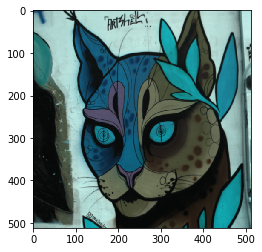

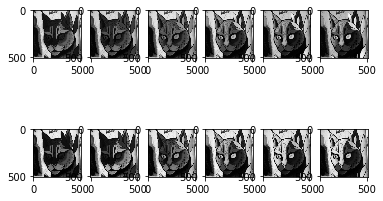

 44%|████▍     | 199/450 [10:26<13:09,  3.14s/it]

mrae[0.017]


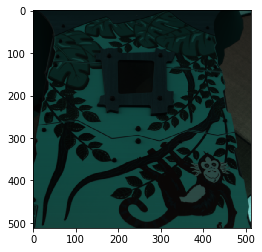

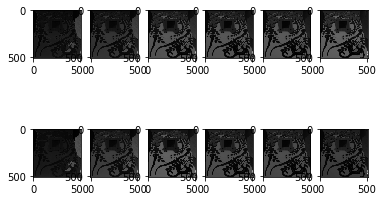

 55%|█████▌    | 249/450 [13:08<10:33,  3.15s/it]

mrae[0.016]


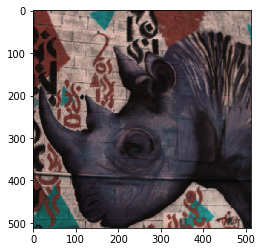

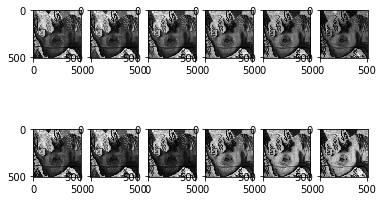

 66%|██████▋   | 299/450 [15:48<07:36,  3.02s/it]

mrae[0.016]


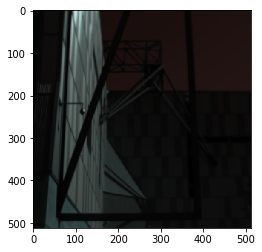

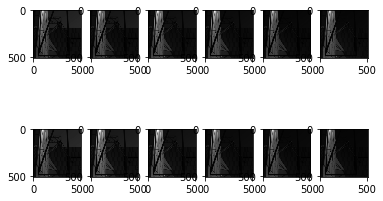

 78%|███████▊  | 349/450 [18:55<05:17,  3.15s/it]

mrae[0.015]


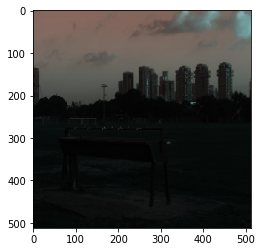

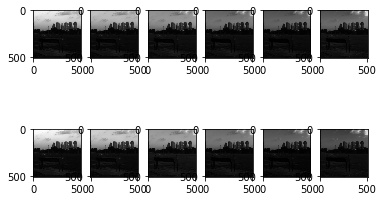

 89%|████████▊ | 399/450 [21:36<03:04,  3.63s/it]

mrae[0.015]


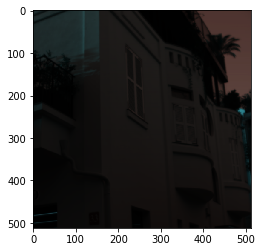

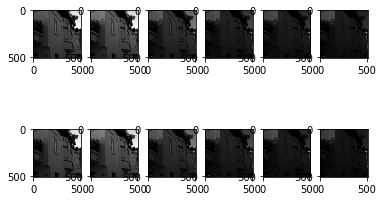

100%|█████████▉| 449/450 [24:12<00:02,  2.92s/it]

mrae[0.015]


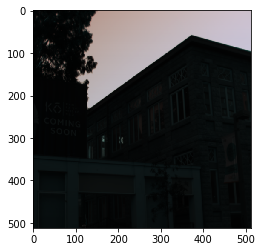

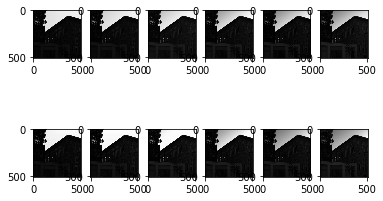

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.001] d2[0.001] g[2.063]
Epoch  3 / 5


 11%|█         | 49/450 [02:40<21:05,  3.16s/it]

mrae[0.017]


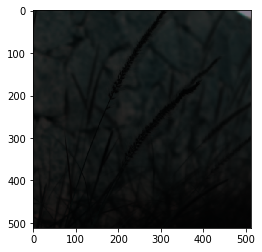

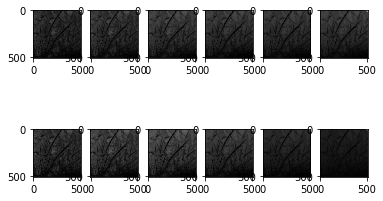

 22%|██▏       | 99/450 [05:30<24:19,  4.16s/it]

mrae[0.015]


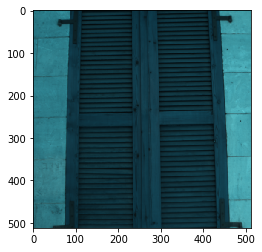

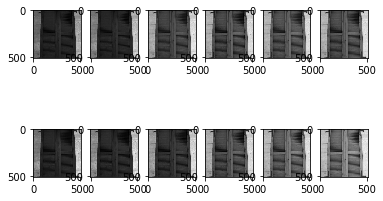

 33%|███▎      | 149/450 [08:20<15:54,  3.17s/it]

mrae[0.014]


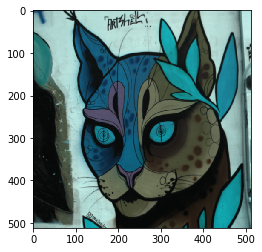

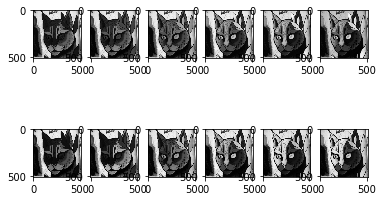

 44%|████▍     | 199/450 [11:07<13:39,  3.26s/it]

mrae[0.014]


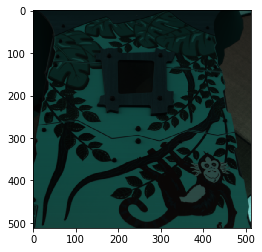

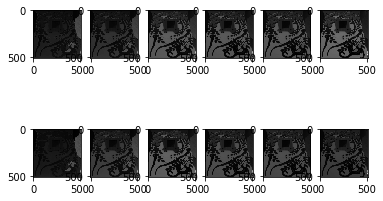

 55%|█████▌    | 249/450 [13:57<10:20,  3.09s/it]

mrae[0.014]


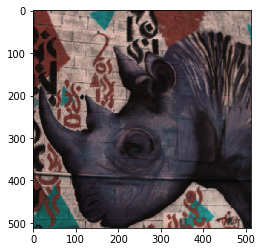

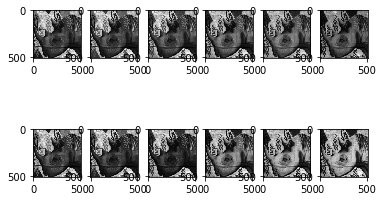

 66%|██████▋   | 299/450 [16:40<08:24,  3.34s/it]

mrae[0.014]


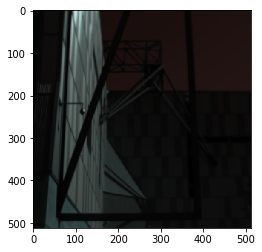

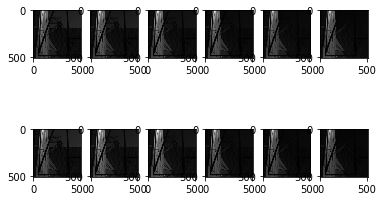

 78%|███████▊  | 349/450 [19:34<05:03,  3.00s/it]

mrae[0.013]


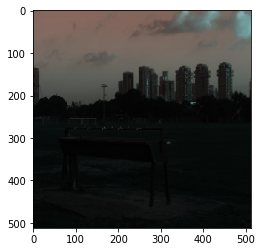

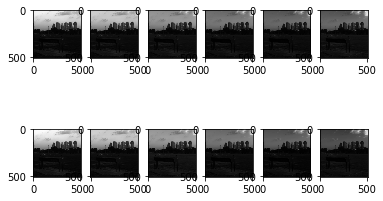

 89%|████████▊ | 399/450 [22:19<02:48,  3.31s/it]

mrae[0.013]


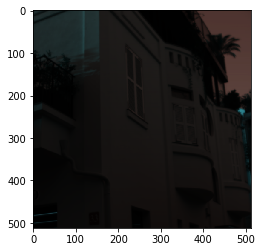

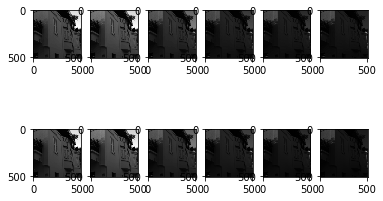

100%|█████████▉| 449/450 [25:03<00:03,  3.06s/it]

mrae[0.013]


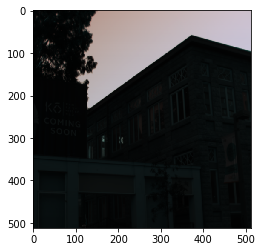

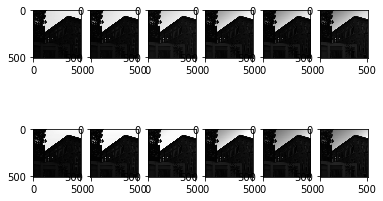

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.000] d2[0.000] g[2.024]
Epoch  4 / 5


 11%|█         | 49/450 [02:33<20:09,  3.02s/it]

mrae[0.015]


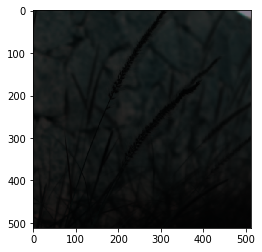

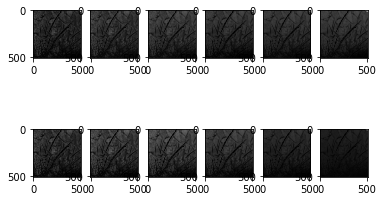

 22%|██▏       | 99/450 [05:23<18:04,  3.09s/it]

mrae[0.014]


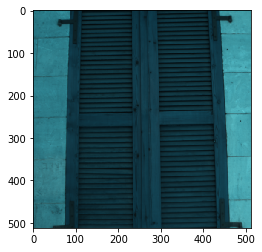

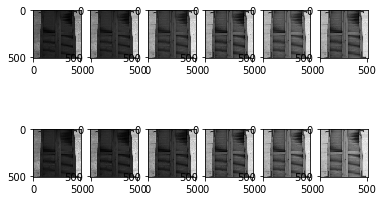

 33%|███▎      | 149/450 [08:05<17:02,  3.40s/it]

mrae[0.013]


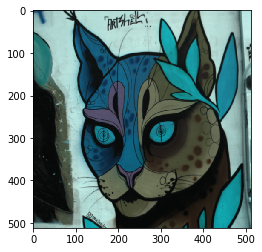

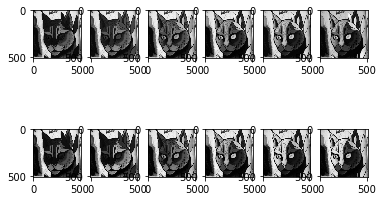

 44%|████▍     | 199/450 [10:46<12:38,  3.02s/it]

mrae[0.013]


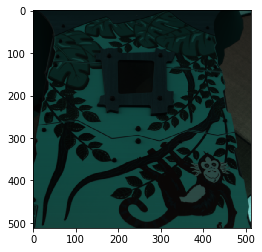

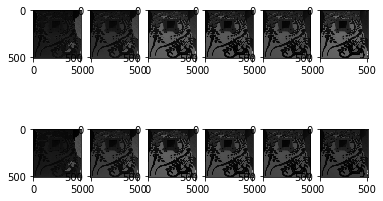

 55%|█████▌    | 249/450 [13:26<10:53,  3.25s/it]

mrae[0.013]


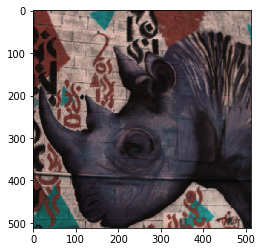

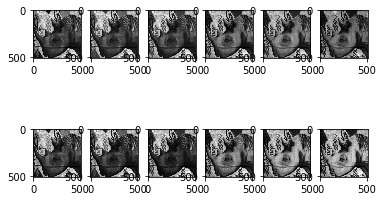

 66%|██████▋   | 299/450 [16:30<08:01,  3.19s/it]

mrae[0.013]


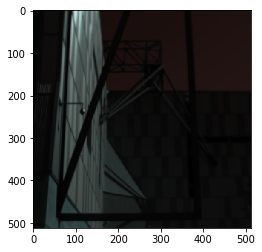

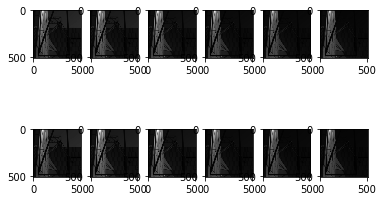

 78%|███████▊  | 349/450 [19:17<05:11,  3.09s/it]

mrae[0.012]


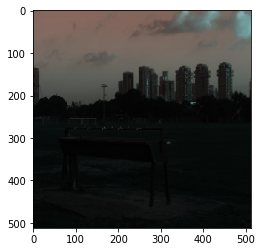

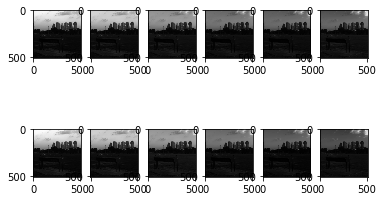

 89%|████████▊ | 399/450 [21:52<02:39,  3.13s/it]

mrae[0.012]


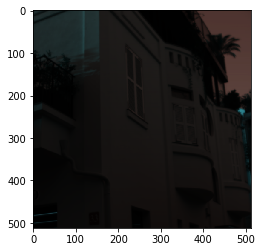

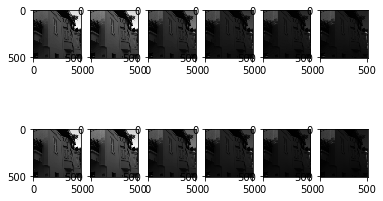

100%|█████████▉| 449/450 [24:26<00:02,  2.98s/it]

mrae[0.012]


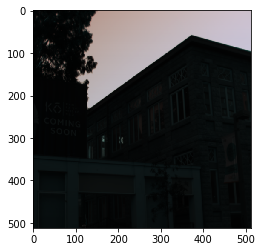

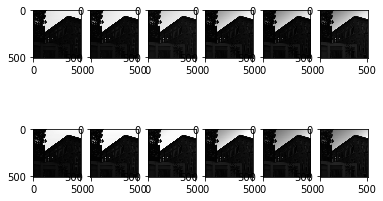

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.000] d2[0.000] g[2.026]
Epoch  5 / 5


 11%|█         | 49/450 [02:35<22:14,  3.33s/it]

mrae[0.014]


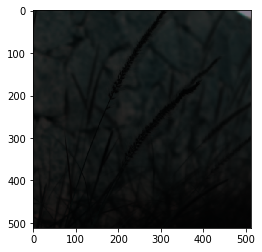

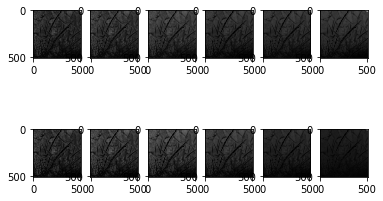

 22%|██▏       | 99/450 [05:16<17:56,  3.07s/it]

mrae[0.013]


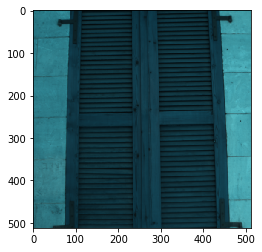

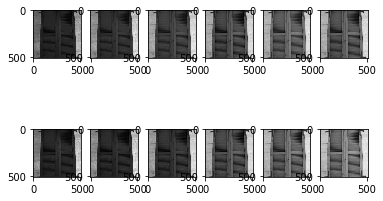

 33%|███▎      | 149/450 [07:51<16:21,  3.26s/it]

mrae[0.012]


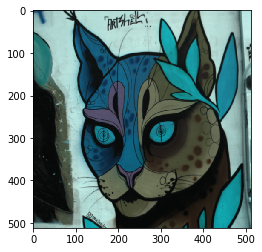

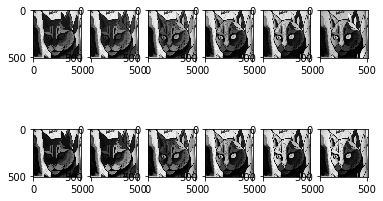

 44%|████▍     | 199/450 [10:41<14:26,  3.45s/it]

mrae[0.013]


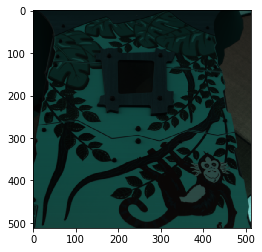

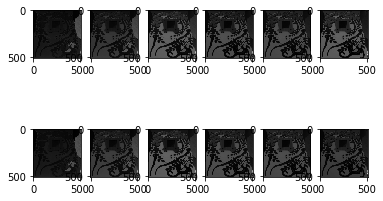

 55%|█████▌    | 249/450 [13:20<11:01,  3.29s/it]

mrae[0.012]


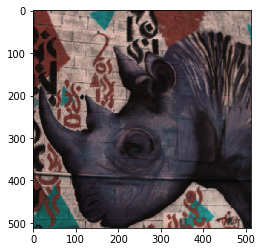

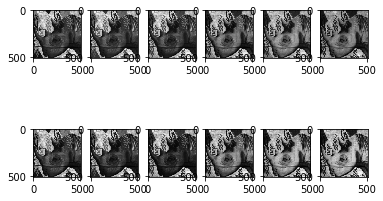

 66%|██████▋   | 299/450 [15:54<07:02,  2.80s/it]

mrae[0.012]


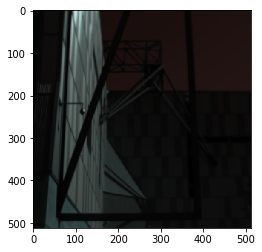

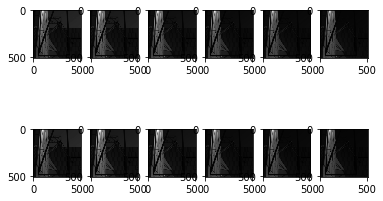

 78%|███████▊  | 349/450 [18:23<05:21,  3.18s/it]

mrae[0.012]


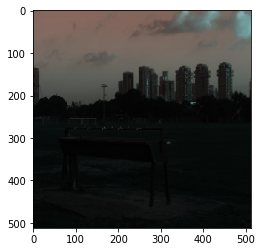

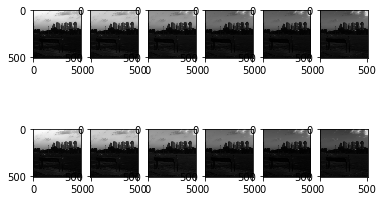

 89%|████████▊ | 399/450 [20:57<02:33,  3.00s/it]

mrae[0.012]


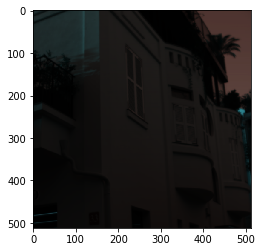

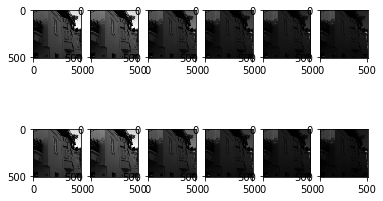

100%|█████████▉| 449/450 [23:34<00:02,  2.83s/it]

mrae[0.011]


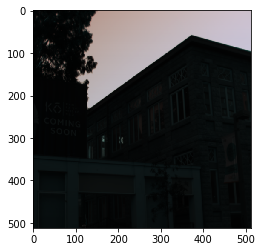

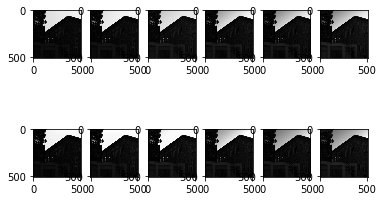

100%|██████████| 450/450 [23:38<00:00,  3.18s/it]

d1[0.000] d2[0.000] g[1.828]


In [13]:
generator = patch_gan.make_generator()
discriminator = patch_gan.make_discriminator()
gan = patch_gan.make_gan(discriminator,generator)
patch_gan.train(generator,discriminator,gan,X_dir = '/home/soham/leadingindia/dataset/NTIRE2020_Train_Clean',y_dir = '/home/soham/leadingindia/dataset/NTIRE2020_Spectral',epochs=5,batch_size=1)

In [29]:
final_model = load_model("generator[000002,000100].h5")

In [14]:
def validation_loss(model,X_val,Y_val,batch_size=1):
    data_loader = data_utils(X_dir=X_val,y_dir = Y_val)
    batch_count = int(data_loader.train_size / batch_size)
    mrae = 0
    for i in range(batch_count):
        rgb,spec = data_loader.load_data_batch(batch_size=batch_size,batch_num=i,patch_num = 0,make_patch=False,resize_img=True)
        generated = model.predict(rgb)
        data_loader.show_sample(rgb,generated,spec)
        mrae += mrae_loss(generated,spec)
    print("mrae = ",mrae/batch_count)
        

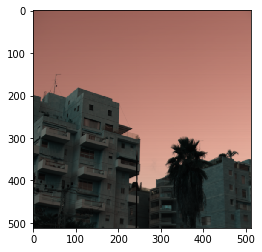

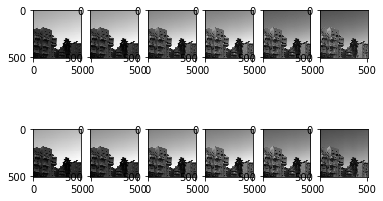

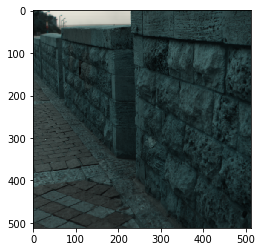

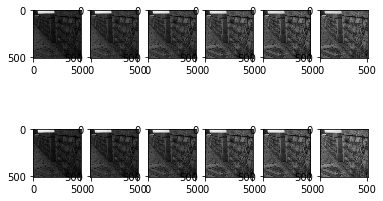

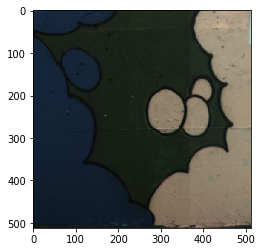

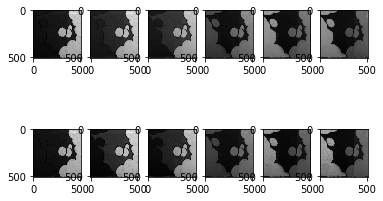

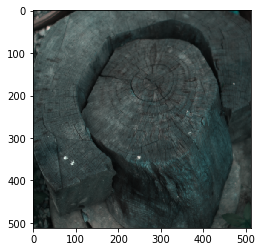

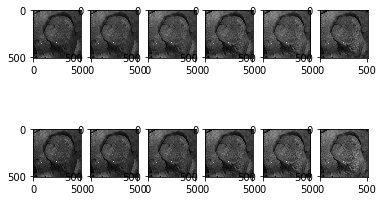

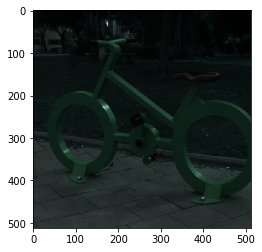

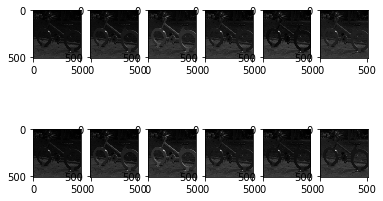

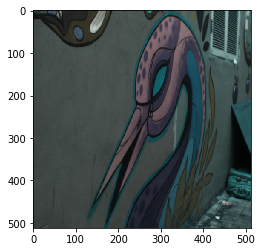

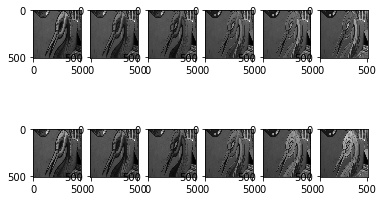

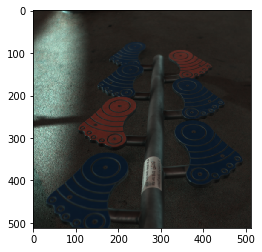

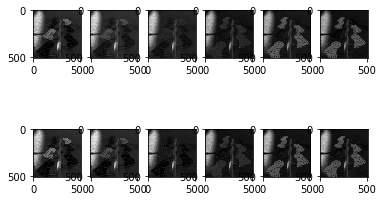

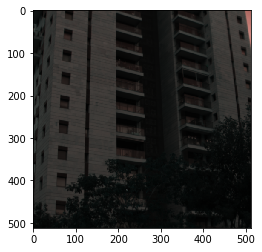

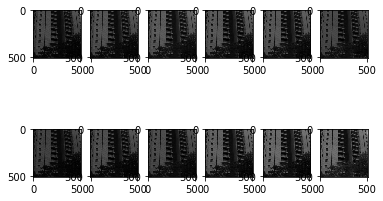

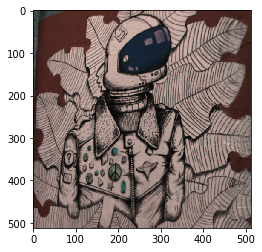

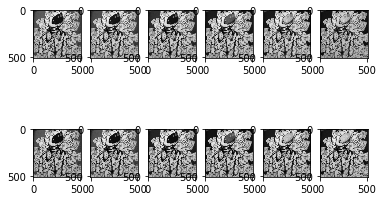

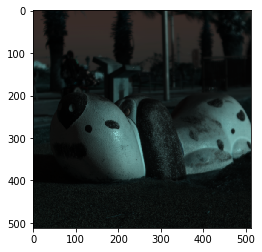

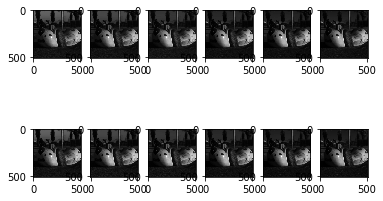

mrae =  tf.Tensor(0.01639354280370758, shape=(), dtype=float64)


In [15]:
validation_loss(generator,X_val = "/home/soham/leadingindia/dataset/NTIRE2020_Validation_Clean/NTIRE2020_Validation_Clean",Y_val="/home/soham/leadingindia/dataset/NTIRE2020_Validation_Spectral/NTIRE2020_Validation_Spectral")

In [ ]:
generator.summary()

In [15]:
discriminator = patch_gan.make_discriminator()

In [16]:
discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 512, 512, 31 0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 512, 512, 34) 0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 64) 34880       concatenate_11[0][0]       

In [17]:
unet_generator = patch_gan.UNet_Generator()

In [18]:
unet_generator.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 256, 256, 64) 3072        input_8[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 128, 128, 128 131072      sequential_15[0][0]              
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 64, 64, 256)  524288      sequential_16[0][0]              
____________________________________________________________________________________________

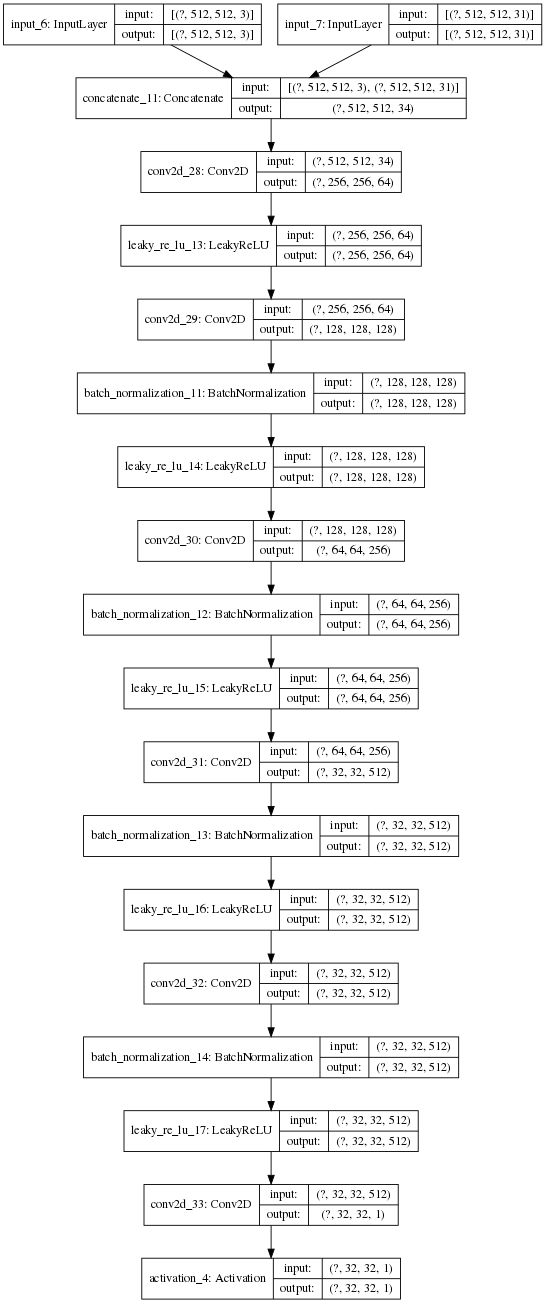

In [19]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [20]:
import pydot

In [21]:
data_loader = data_utils(X_dir='/home/soham/leadingindia/dataset/NTIRE2020_Train_Clean',y_dir = '/home/soham/leadingindia/dataset/NTIRE2020_Spectral')
rgb,spec = data_loader.load_data_batch(batch_size=1,batch_num=1,make_patch=False)
plt.imshow(rgb.reshape(rgb.shape[1:]))
plt.show()
plt.imshow(spec[0,:,:,1])
plt.show()

TypeError: load_data_batch() missing 1 required positional argument: 'patch_num'

In [ ]:
spec[0,:,:,1].shape

In [ ]:
f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(rgb[0])
axarr[0,1].imshow(spec[0,:,:,2])
axarr[0,2].imshow(spec[0,:,:,7])
axarr[0,3].imshow(spec[0,:,:,12])
axarr[1,0].imshow(spec[0,:,:,17])
axarr[1,1].imshow(spec[0,:,:,22])
axarr[1,2].imshow(spec[0,:,:,27])
axarr[1,3].imshow(spec[0,:,:,25])
plt.show()